In [188]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

In [189]:
from sklearn.tree import (DecisionTreeClassifier as DTC, 
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
    (RandomForestRegressor as RF,
     GradientBoostingRegressor as GBR)
from ISLP.bart import BART

# Homework 1
## Problem 2
### Part a)

In [190]:
Carseats = load_data('Carseats')
y = Carseats['Sales']
model = MS(Carseats.columns.drop('Sales'), intercept = False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)


In [191]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                y,
                                test_size = 0.3,
                                random_state = 0)
# print(y_train)

### Part b)

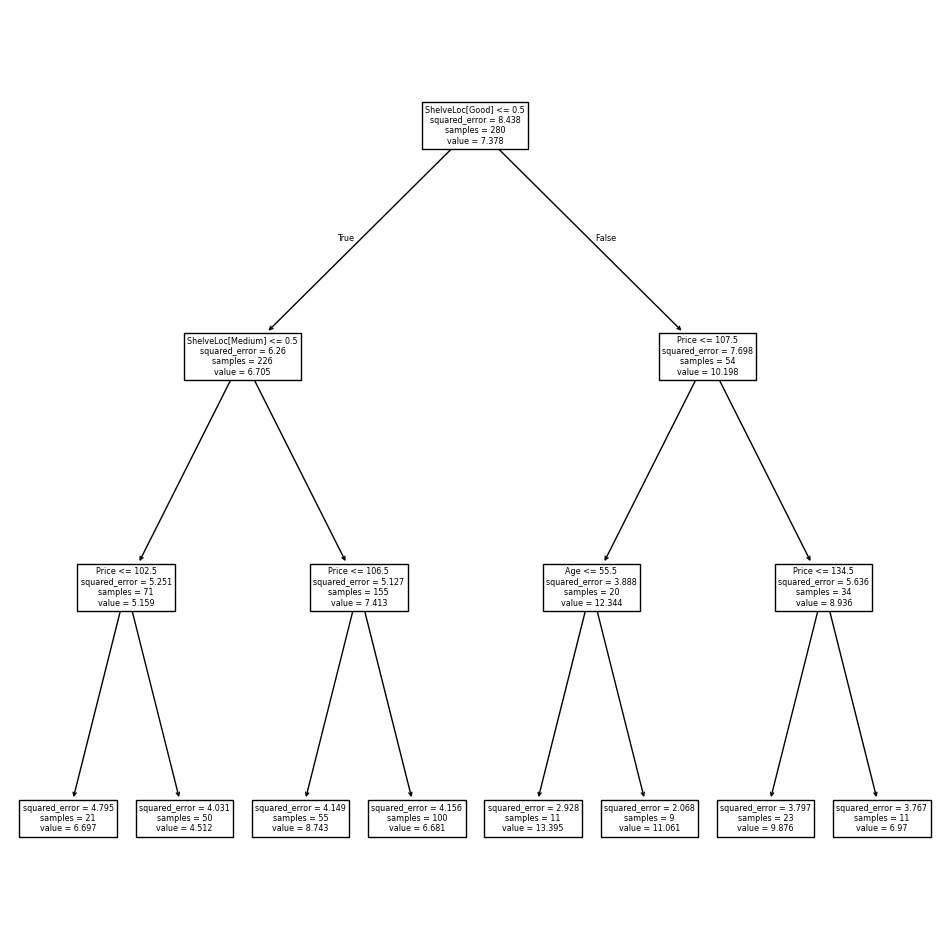

In [192]:
reg = DTR(max_depth = 3)
reg.fit(X_train, y_train)
ax = plt.subplots(figsize = (12, 12))[1]
plot_tree(reg,
          feature_names = feature_names,
          ax = ax);

In [193]:
print(y.describe())
TestMSE1b = np.mean((y_test - reg.predict(X_test))**2)
print("Testing MSE: ", TestMSE1b)

count    400.000000
mean       7.496325
std        2.824115
min        0.000000
25%        5.390000
50%        7.490000
75%        9.320000
max       16.270000
Name: Sales, dtype: float64
Testing MSE:  3.703858275236094


We get a testing MSE lower than the variance of Sales column, which is not catastrophically bad.
### Part c)

In [194]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle = True,
                  random_state = 10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit = True,
                        cv = kfold,
                        scoring = 'neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [195]:
best_ = grid.best_estimator_
TestMSE1c = np.mean((y_test - best_.predict(X_test))**2)
print("Testing MSE: ", TestMSE1c)
print("Difference in testing MSE: ", TestMSE1c - TestMSE1b)

Testing MSE:  3.7038582752360942
Difference in testing MSE:  4.440892098500626e-16


The testing MSE is negligeably larger than in part b), which means we chose a good model in part b).
### Part d)

In [196]:
bag_carseats = RF(max_features = X_train.shape[1], random_state = 0)
bag_carseats.fit(X_train, y_train)

RandomForestRegressor(max_features=11, random_state=0)

In [197]:
y_hat_bag = bag_carseats.predict(X_test)
TestMSE1d = np.mean((y_test - y_hat_bag)**2)
print("Testing MSE: ", TestMSE1d)

Testing MSE:  2.0077445197500015


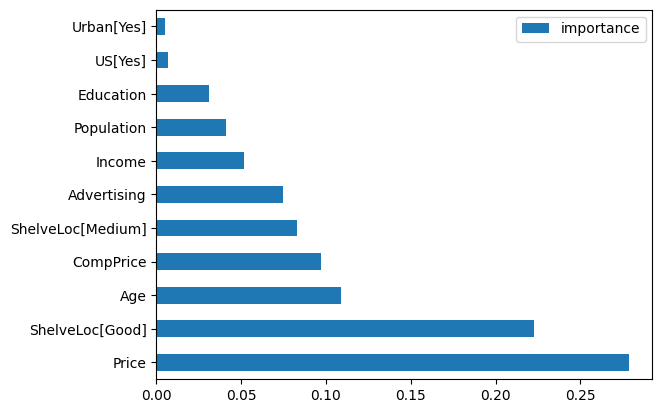

In [198]:
feature_imp = pd.DataFrame(
    {'importance': bag_carseats.feature_importances_},
    index = feature_names)
feature_imp.sort_values(by = 'importance',
                        ascending = False).plot(kind = 'barh');

Here we used the fact that bagging is a special case of random forest, with $m=p$. The testing MSE is lower than in part b) and c). We see that price and good Shelve Location are by far the most important features.

### Part e)

In [199]:
RF_carseats = RF(max_features = int(np.sqrt(X_train.shape[1])), random_state = 0).fit(X_train, y_train)
y_hat_RF = RF_carseats.predict(X_test)
TestMSE1e = np.mean((y_test - y_hat_RF)**2)
print("Testing MSE: ", TestMSE1e)

Testing MSE:  2.303643984083332


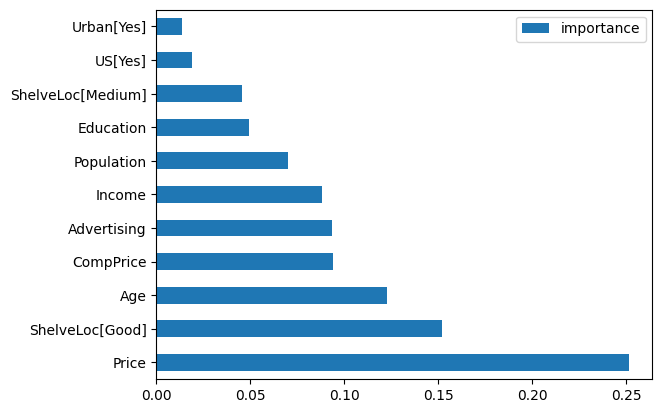

In [200]:
feature_imp = pd.DataFrame(
    {'importance': RF_carseats.feature_importances_},
    index = feature_names)
feature_imp.sort_values(by = 'importance',
                        ascending = False).plot(kind = 'barh');

The error rate increases for $m=\sqrt{p}$, although the important variables are the same

In [201]:
bart_carseats = BART(random_state = 0, burnin= 5, ndraw = 15)
bart_carseats.fit(X_train, y_train)

BART(burnin=5, ndraw=15, random_state=0)

In [202]:
yhat_test = bart_carseats.predict(X_test.astype(np.float32))
TestMSE1f = np.mean((y_test - yhat_test)**2)
print("Testing MSE: ", TestMSE1f)

Testing MSE:  1.7171824254893664


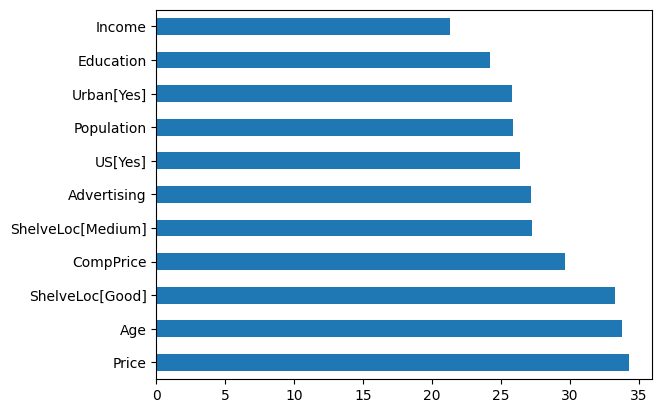

In [203]:
var_inclusion = pd.Series(bart_carseats.variable_inclusion_.mean(0),
                          index = D.columns)
var_inclusion.sort_values(ascending = False).plot(kind = 'barh');

Here we get the lowest testing MSE so far and bart uses all the variables almost an equal amount of times.
## Problem 3
### Part a)

In [204]:
Hitters = pd.read_csv('ISLRv2_data\ALL CSV FILES - 2nd Edition\Hitters.csv')
Hitters = Hitters.dropna()
Hitters['Salary'] = np.log(Hitters['Salary'])
Hitters['League'] = Hitters['League'].astype('category')
Hitters['Division'] = Hitters['Division'].astype('category')
Hitters['NewLeague'] = Hitters['NewLeague'].astype('category')

### Part b)

In [205]:
y = Hitters['Salary']
model = MS(Hitters.columns.drop('Salary'), intercept = False)
D = model.fit_transform(Hitters)
feature_names = list(D.columns)
X = np.asarray(D)
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                y,
                                train_size = 200/len(X),
                                random_state = 0)

### Part c) and d)

In [206]:
def Boosting(shrinkage_parameter):
    boost_hitters = GBR(n_estimators = 1000,
                        learning_rate = shrinkage_parameter,
                        max_depth = 3,
                        random_state = 0)
    boost_hitters.fit(X_train, y_train)
    return boost_hitters

In [ ]:
lambdas = np.logspace(-3, 0, 10)
TrainingMSE, TestingMSE = [], []
for l in lambdas:
    boost_hitters = Boosting(l)
    TrainingMSE.append(boost_hitters.train_score_[-1])
    TestingMSE.append(np.mean((y_test - boost_hitters.predict(X_test))**2))

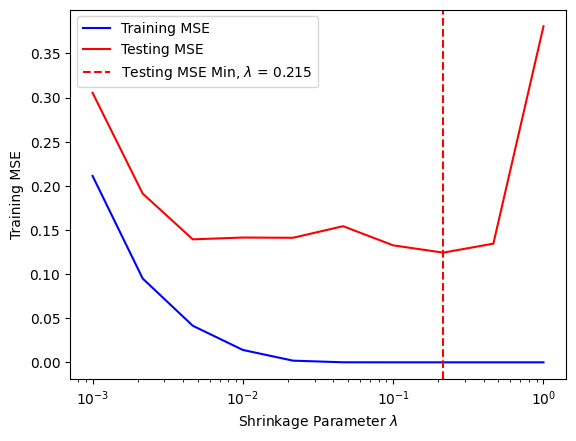

In [208]:
plt.plot(lambdas, TrainingMSE, label = 'Training MSE', color = 'blue')
plt.plot(lambdas, TestingMSE, label = 'Testing MSE', color = 'red')

optimal_lambda = lambdas[np.argmin(TestingMSE)]
plt.axvline(optimal_lambda, color = 'red', linestyle = '--', label = 'Testing MSE Min, $\lambda$ = ' + str(round(optimal_lambda, 3)))
plt.xscale('log')
plt.xlabel('Shrinkage Parameter $\lambda$')
plt.ylabel('Training MSE')
plt.legend();

The optimal shrinkage value is $\lambda = 0.215$.
### Part e)

In [209]:
boost_hitters = Boosting(optimal_lambda)

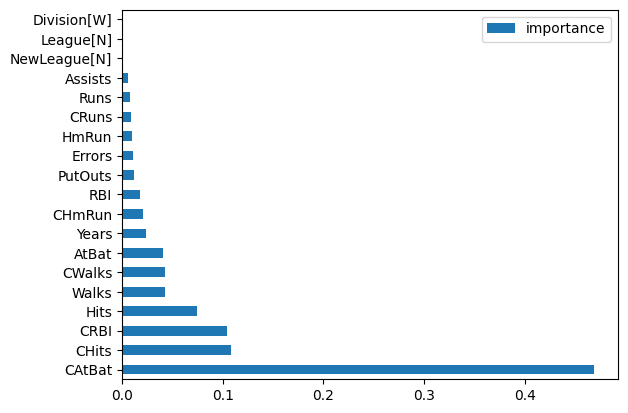

In [210]:
feature_imp = pd.DataFrame(
    {'importance': boost_hitters.feature_importances_},
    index = feature_names)
feature_imp.sort_values(by = 'importance',
                        ascending = False).plot(kind = 'barh');

CAtBat has by far the largest importance, followed by CRBI and CHits. The other variables are almost irrelevant.

### Part f)

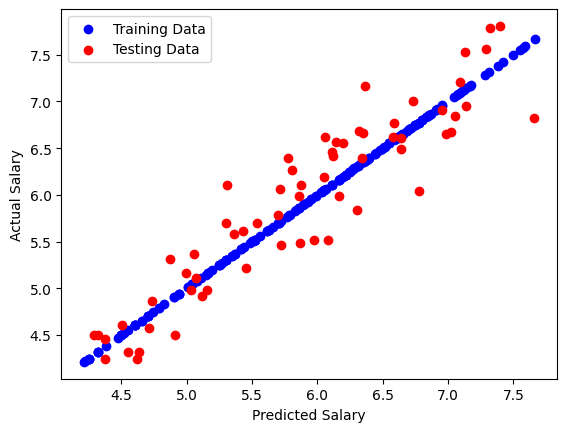

In [211]:
predicted_salary_train = boost_hitters.predict(X_train)
predicted_salaray_test = boost_hitters.predict(X_test)
plt.scatter(predicted_salary_train, y_train, color = 'blue', label = 'Training Data')
plt.scatter(predicted_salaray_test, y_test, color = 'red', label = 'Testing Data')
plt.xlabel('Predicted Salary')
plt.ylabel('Actual Salary')
plt.legend();

The training data follows almost a y=x line, which is expected. The testing data is more noisy, but still follows the y=x line.
### part g)

In [212]:
import statsmodels.api as sm

In [215]:
X = MS().fit_transform(X_train)
model = sm.GLM(
    y_train
    , X
    )
regr = model.fit()
TestMSEGLM = np.mean((y_test - regr.predict(MS().fit_transform(X_test)))**2)
print("Testing MSE GLM: ", TestMSEGLM)
print("Testing MSE Boosting: ", np.min(TestingMSE))

Testing MSE GLM:  0.9054964367508577
Testing MSE Boosting:  0.12426807742910123


We achieve a much lower testing MSE in boosting than for a generalized linear model. We could still use best subset selection or the like, to improbe the GLM.
### Part h)

In [216]:
bag_carseats = RF(max_features = X_train.shape[1], random_state = 0)
bag_carseats.fit(X_train, y_train)
y_hat_bag = bag_carseats.predict(X_test)
TestMSE1d = np.mean((y_test - y_hat_bag)**2)
print("Testing MSE: ", TestMSE1d)

Testing MSE:  0.14022674029027116


Almost as low as the testing MSE for boosting, but a lot less computationally expensive.